In [3]:
import arpa_cleaning as ac
import netatmo_cleaning as nc
import numpy as np
import os
import folium
import pandas as pd
import geopandas as gpd
import seaborn as sns
from pathlib import Path
import warnings
import ipywidgets as widgets
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', None)

In [4]:
%reload_ext autoreload

# ARPA Pre-processing

Cleaning of ARPA stations, only removing -999 values and outliers based on z-scores. After, we create ARPA virtual station with mean and standard deviation values.

In [ ]:
ARPA_folder_path = '../ARPA/'

In [ ]:
original_arpa_data = pd.read_parquet(ARPA_folder_path + 'ARPA_2022_CML_roi.parquet')

In [ ]:
(original_arpa_data['Medio'] == -999).any()
(original_arpa_data['Medio'] == -999).sum()

In [ ]:
# Replace missing values (-999) as Nan
original_arpa_data['Medio'] = original_arpa_data['Medio'].replace(-999, np.nan)

In [ ]:
original_arpa_data

In [ ]:
original_arpa_data.isna().sum()

In [ ]:
unique_datetimes = original_arpa_data['Data-Ora'].nunique()
print(f"Unique datetime values: {unique_datetimes}")

In [ ]:
def remove_monthly_outliers(temp_df):
    pd.set_option('mode.chained_assignment', None)

    temp_df['Data-Ora'] = pd.to_datetime(temp_df['Data-Ora'])

    # Add year and month columns
    temp_df['year'] = temp_df['Data-Ora'].dt.year
    temp_df['month'] = temp_df['Data-Ora'].dt.month

    result = []

    for (year, month), group in temp_df.groupby(['year', 'month']):
        group = group.copy()
        mean = group['Medio'].mean()
        std = group['Medio'].std()
        group['zscore'] = (group['Medio'] - mean) / std

        # Mark outliers
        mask_outlier = (group['zscore'] > 3) | (group['zscore'] < -3)

        # Replace outliers in 'Medio' with NaN, keep the rest of the data
        group.loc[mask_outlier, 'Medio'] = np.nan

        result.append(group)

    cleaned_full_year = pd.concat(result).sort_values(by='Data-Ora').reset_index(drop=True)

    return cleaned_full_year

In [ ]:
cleaned_arpa = remove_monthly_outliers(original_arpa_data)

In [ ]:
cleaned_arpa

In [ ]:
cleaned_arpa.isna().sum()

In [ ]:
cleaned_arpa.sort_values(by='zscore', ascending=False).head(20)

In [ ]:
cleaned_arpa = cleaned_arpa.rename(columns={
    'Data-Ora': 'Datetime',
    'Medio': 'Temp',
    'Id Sensore': 'Id'
})

cleaned_arpa = cleaned_arpa.drop(columns=['year', 'month'])

In [ ]:
cleaned_arpa

In [ ]:
# Export cleaned ARPA data to parquet
cleaned_arpa.to_parquet("../ARPA/parquet/ARPA_2022_full/ARPA_2022_fullyear_cleaned.parquet")

Create ARPA virtual station from loaded data

In [ ]:
# Ensure 'Data' is datetime
cleaned_arpa['Datetime'] = pd.to_datetime(cleaned_arpa['Datetime'], errors='coerce')

# Drop any rows with missing timestamps or values
#ARPA_df = ARPA_df.dropna(subset=['Data-Ora', 'Medio'])

# Group by timestamp and calculate both mean and standard deviation
ARPA_virtual_station = cleaned_arpa.groupby('Datetime')['Temp'].agg(Temp_mean='mean', Temp_std='std').reset_index()

# Show result
print(f"Virtual station shape: {ARPA_virtual_station.shape}")
print(ARPA_virtual_station.head())

In [ ]:
ARPA_virtual_station

In [ ]:
ARPA_virtual_station.to_parquet("../ARPA/parquet/ARPA_2022_full/ARPA_virtual_station_2022.parquet")

# CML Pre-processing

## Initial pre-processing

The first part of the code does some checks and preparation of CML data, such as filling in the missing datetime values for consistency. It removes unrealistic values (above 50 °C and below -20 °C). Also, we calculate the percentage of missing data per station. 
After that, we create two dfs, one of stations at 5-min intervals and another of stations at 1-min intervals.

In [ ]:
# Here we just check the number of rows which have values above 50 °C and below -20 °C (per station). This step is repeated in the next cell of this code within one larger cleaning pipeline.

folder_path = Path('./CML_txt_export/')
all_files = list(folder_path.glob("*.csv"))

for file in all_files:
    try:
        df = pd.read_csv(file)
        station_name = file.stem

        # Replace '---' with NaN and convert to numeric
        df['Temp'] = pd.to_numeric(df['Temp'].replace('---', pd.NA), errors='coerce')

        # Drop missing values before counting
        df = df.dropna(subset=['Temp'])

        count_before = len(df)

        # Identify out-of-range values (sensor errors)
        sensor_issue_mask = (df['Temp'] < -20) | (df['Temp'] > 50)
        sensor_issues = df[sensor_issue_mask]
        count_removed = sensor_issues.shape[0]

        # Remove out-of-range values
        df = df[~sensor_issue_mask]
        count_after = len(df)

        print(f"{station_name}: {count_before} → {count_after} (removed {count_removed} rows (below -20 °C and above 50 °C))")

    except Exception as e:
        print(f"Error in {file.name}: {e}")

**Total number of rows removed which are below -20 °C and above 50 °C across all sensors is: 36.**

In [ ]:
folder_path = Path('./CML_txt_export/')
one_min_stations = ['mi_sansiro', 'rovagnasco', 'sedriano']

In [ ]:
# Function to do initial preprocessing

dfs_5min, dfs_1min = [], []
inserted_counts_5min = {}
inserted_counts_1min = {}

nan_percentage_5min = {}  # To store NaN percentage for 5-min data
nan_percentage_1min = {}  # To store NaN percentage for 1-min data

total_rows_5min = {}
total_rows_1min = {}

def clean_and_fill(df, station_name, freq):
    # Replace '---' with NaN and convert Temp
    df.replace('---', np.nan, inplace=True)
    df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')

    # Count NaNs BEFORE anything else
    original_nans = df['Temp'].isna().sum()

    # Drop unrealistic values
    df['Temp'] = df['Temp'].mask((df['Temp'] < -20) | (df['Temp'] > 50))

    # Count how many were masked
    masked_nans = df['Temp'].isna().sum() - original_nans
    
    # Parse datetime
    df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
    df = df.dropna(subset=['Datetime'])

    # Drop duplicates and sort
    df = df.sort_values('Datetime').drop_duplicates('Datetime')

    # Count how many were masked
    masked_nans = df['Temp'].isna().sum() - original_nans

    # DST Fixes
    march_27 = pd.Timestamp("2022-03-27")
    march_shift_mask = (
        (df['Datetime'].dt.date == march_27.date()) &
        (df['Datetime'].dt.hour == 3)
    )
    df.loc[march_shift_mask, 'Datetime'] -= pd.Timedelta(hours=1)

    after_march_mask = df['Datetime'] > pd.Timestamp("2022-03-27 03:59:59")
    df.loc[after_march_mask, 'Datetime'] -= pd.Timedelta(hours=1)

    df.loc[df['Datetime'] > pd.Timestamp("2022-10-30 02:59:59"), 'Datetime'] += pd.Timedelta(hours=1)

    df = df.sort_values('Datetime').drop_duplicates('Datetime')

    # Define date range
    if freq == '5min':
        start = pd.Timestamp('2022-01-01 00:05')
    elif freq == '1min':
        start = pd.Timestamp('2022-01-01 00:01')
    else:
        raise ValueError(f"Unsupported frequency: {freq}")

    end = pd.Timestamp('2023-01-01 00:00')
    full_index = pd.date_range(start=start, end=end, freq=freq)

    # Reindex (inserting new NaNs)
    df = df.set_index('Datetime')
    df = df.reindex(full_index)

    # Count NaNs after reindex (original + inserted)
    total_nans = df['Temp'].isna().sum()
    final_nans = total_nans - masked_nans

    # Save to correct dictionary
    if freq == '1min':
        inserted_counts_1min[station_name] = final_nans
        total_rows_1min[station_name] = len(df)
        nan_percentage_1min[station_name] = (final_nans / len(df)) * 100
    else:
        inserted_counts_5min[station_name] = final_nans
        total_rows_5min[station_name] = len(df)
        nan_percentage_5min[station_name] = (final_nans / len(df)) * 100

    # Finalize
    df = df[['Temp']].reset_index()
    df.rename(columns={'index': 'Datetime'}, inplace=True)
    df['station'] = station_name

    return df, final_nans

In [ ]:
# Processing loop for all CSV files
for file in folder_path.glob("*.csv"):
    station_name = file.stem.lower()  # station name from filename
    freq = '1min' if station_name in one_min_stations else '5min'

    try:
        df = pd.read_csv(file)
        cleaned_df, inserted = clean_and_fill(df, station_name, freq)

        if freq == '1min':
            dfs_1min.append(cleaned_df)
            inserted_counts_1min[station_name] = inserted
        else:
            dfs_5min.append(cleaned_df)
            inserted_counts_5min[station_name] = inserted
    except Exception as e:
        print(f"Error processing {station_name}: {e}")

# Concatenate all cleaned dataframes
df_all_5min = pd.concat(dfs_5min, ignore_index=True)
df_all_1min = pd.concat(dfs_1min, ignore_index=True)

In [ ]:
# Build summary tables
summary_5min = pd.DataFrame([
    {
        'Station': s,
        'NaN Percentage': nan_percentage_5min[s],
        'Total NaNs': inserted_counts_5min[s],
        'Total Rows': total_rows_5min[s]
    }
    for s in inserted_counts_5min
]).sort_values(by='NaN Percentage', ascending=False)

summary_1min = pd.DataFrame([
    {
        'Station': s,
        'NaN Percentage': nan_percentage_1min[s],
        'Total NaNs': inserted_counts_1min[s],
        'Total Rows': total_rows_1min[s]
    }
    for s in inserted_counts_1min
]).sort_values(by='NaN Percentage', ascending=False)

print("Summary for 5-min:")
print(summary_5min)

print("\nSummary for 1-min:")
print(summary_1min)

# Overall totals
total_missing_5min = sum(inserted_counts_5min.values())
total_rows_all_5min = sum(total_rows_5min.values())
total_nan_pct_5min = (total_missing_5min / total_rows_all_5min) * 100

total_missing_1min = sum(inserted_counts_1min.values())
total_rows_all_1min = sum(total_rows_1min.values())
total_nan_pct_1min = (total_missing_1min / total_rows_all_1min) * 100

print("\n--- Overall Missing Data Summary ---")
print(f"5-min → Total Missing: {int(total_missing_5min):,} / {total_rows_all_5min:,} "
      f"({total_nan_pct_5min:.2f}% missing)")

print(f"1-min → Total Missing: {int(total_missing_1min):,} / {total_rows_all_1min:,} "
      f"({total_nan_pct_1min:.2f}% missing)")

Missing data here is the result of changing '---' to NaN or inserting where we inserted rows due to missing Datetime.

In [ ]:
print(df_all_5min)

In [ ]:
df_all_5min, df_all_1min

In [ ]:
# It's a large dataset, let's export it to parquet file for faster loading later
df_all_5min.to_parquet("./CML_txt_export/CML_5min_not_cleaned.parquet")
df_all_1min.to_parquet("./CML_txt_export/CML_1min_not_cleaned.parquet")

In [ ]:
unique_datetimes = df_all_5min['Datetime'].nunique()
print(f"Unique datetime values: {unique_datetimes}")

In [ ]:
num_stations = df_all_1min['station'].nunique()
print(f"Number of stations in df: {num_stations}")

## Plotting part

Aggregate 5-min and 1-min intervals into new dfs at 10-min intervals and create interactive plotting to compare ARPA and CML visually.

In [ ]:
# Load parquet files
df_5min = pd.read_parquet("./CML_txt_export/CML_5min_not_cleaned.parquet")
df_1min = pd.read_parquet("./CML_txt_export/CML_1min_not_cleaned.parquet")

df_5min['Datetime'] = pd.to_datetime(df_5min['Datetime'])  # ensure it's datetime
df_1min['Datetime'] = pd.to_datetime(df_1min['Datetime'])  # ensure it's datetime

#df_5min.set_index('Datetime', inplace=True)
#df_1min.set_index('Datetime', inplace=True)

In [ ]:
df_5min, df_1min

In [ ]:
# Here we merge 5_min and 1_min data and create a new df to hold values for all 63 stations at 10-min interval that fit ARPA

def average_chunks_fast(df, chunk_size):
    results = []
    for station, group in df.groupby('station'):
        group = group.sort_values('Datetime').reset_index(drop=True)
        n_chunks = len(group) // chunk_size
        if n_chunks == 0:
            continue
        truncated = group.iloc[:n_chunks * chunk_size]
        reshaped = truncated['Temp'].values.reshape(-1, chunk_size)
        
        # Suppress only the specific runtime warning
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            mean_temps = np.nanmean(reshaped, axis=1)

        timestamps = truncated['Datetime'].values.reshape(-1, chunk_size)[:, 0]
        timestamps = pd.to_datetime(timestamps).floor('10T')

        result_df = pd.DataFrame({
            'Datetime': timestamps,
            'Temp': mean_temps,
            'station': station
        })
        results.append(result_df)
    return pd.concat(results, ignore_index=True)

df_5min_avg = average_chunks_fast(df_5min, chunk_size=2)
df_1min_avg = average_chunks_fast(df_1min, chunk_size=10)
df_10min = pd.concat([df_5min_avg, df_1min_avg]).sort_values(['station', 'Datetime']).reset_index(drop=True)

In [ ]:
df_10min

In [ ]:
# Create CML virtual station by averaging across all stations for each timestamp
# Create CML virtual station by averaging across all stations for each timestamp
cml_virtual_station = df_10min.groupby('Datetime')['Temp'].agg(Temp_mean='mean', Temp_std='std').reset_index()
cml_virtual_station['station'] = 'CML_Virtual'

In [ ]:
cml_virtual_station

In [ ]:
cml_virtual_station = cml_virtual_station.sort_values('Datetime').reset_index(drop=True)

# Shift up by 1
cml_virtual_station['Temp_mean'] = cml_virtual_station['Temp_mean'].shift(-1)
cml_virtual_station['Temp_std'] = cml_virtual_station['Temp_std'].shift(-1)

In [ ]:
cml_virtual_station

In [ ]:
# Create dropdowns for station and month selection
station_dropdown = widgets.Dropdown(
    options=sorted(df_10min['station'].unique()),
    description='station:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

month_dropdown = widgets.Dropdown(
    options=[('All', 'all')] + [(str(i), i) for i in range(1, 13)],
    description='Month:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

day_dropdown = widgets.Dropdown(
    options=[('All', 'all')] + [(str(i), i) for i in range(1, 32)],
    description='Day:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

In [ ]:
def plot_virtual_comparison(month, day):
    # Load and filter ARPA data
    arpa_filtered = pd.read_parquet("../ARPA/parquet/ARPA_2022_full/ARPA_virtual_station_2022.parquet")
    arpa_filtered = arpa_filtered[arpa_filtered['Datetime'].dt.year == 2022]

    # Use your precomputed CML virtual station DataFrame
    cml_virtual = cml_virtual_station[cml_virtual_station['Datetime'].dt.year == 2022]

    # Filter by month
    if month != 'all':
        arpa_filtered = arpa_filtered[arpa_filtered['Datetime'].dt.month == month]
        cml_virtual = cml_virtual[cml_virtual['Datetime'].dt.month == month]

    # Filter by day
    if day != 'all':
        arpa_filtered = arpa_filtered[arpa_filtered['Datetime'].dt.day == day]
        cml_virtual = cml_virtual[cml_virtual['Datetime'].dt.day == day]

    # Drop NaNs
    cml_virtual = cml_virtual.dropna(subset=['Temp_mean', 'Temp_std', 'Datetime'])
    arpa_filtered = arpa_filtered.dropna(subset=['Temp_mean', 'Temp_std', 'Datetime'])

    if cml_virtual.empty and arpa_filtered.empty:
        print("No data available for this selection.")
        return

    # Plotting
    plt.figure(figsize=(15, 4))

    # Plot CML virtual
    plt.plot(cml_virtual['Datetime'], cml_virtual['Temp_mean'], color='tab:blue', marker='.', linestyle='-', markersize=1.5, label='CML Virtual Temp')

    # Plot ARPA virtual
    plt.plot(arpa_filtered['Datetime'], arpa_filtered['Temp_mean'], color='tab:orange', marker='.', linestyle='-', markersize=1.5, label='ARPA Virtual Temp')

    # Plot ARPA std deviation shading
    plt.fill_between(arpa_filtered['Datetime'],
                     arpa_filtered['Temp_mean'] - 3 * arpa_filtered['Temp_std'],
                     arpa_filtered['Temp_mean'] + 3 * arpa_filtered['Temp_std'],
                     color='tab:orange', alpha=0.3, label='ARPA ±3 STD')

    # Plot CML std deviation shading
    plt.fill_between(cml_virtual['Datetime'],
                     cml_virtual['Temp_mean'] - 3 * cml_virtual['Temp_std'],
                     cml_virtual['Temp_mean'] + 3 * cml_virtual['Temp_std'],
                     color='tab:blue', alpha=0.3, label='CML ±3 STD')

    # Title
    title = "CML Virtual vs ARPA Virtual - "
    if month == 'all':
        title += "Full Year 2022"
    elif day == 'all':
        title += f"Month {month} (2022)"
    else:
        title += f"{month}/{day}/2022"
    plt.title(title)
    plt.xlabel("Datetime")
    plt.ylabel("Temperature [°C]")
    plt.grid(True)

    # X-axis formatting
    ax = plt.gca()
    if month == 'all':
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    elif day == 'all':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    else:
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run interactive widget for virtual comparison
widgets.interact(plot_virtual_comparison, month=month_dropdown, day=day_dropdown)

In [ ]:
# Plotting function
def plot_station_month_day(station, month, day):
    # Copy and filter df_all_10min
    df = df_10min.copy()
    df_filtered = df[df['station'] == station]
    df_filtered = df_filtered[df_filtered['Datetime'].dt.year == 2022]

    # Filter ARPA data
    arpa_filtered = pd.read_parquet("../ARPA/parquet/ARPA_2022_full/ARPA_virtual_station_2022.parquet")
    arpa_filtered = arpa_filtered[arpa_filtered['Datetime'].dt.year == 2022]

    # Filter by month
    if month != 'all':
        df_filtered = df_filtered[df_filtered['Datetime'].dt.month == month]
        arpa_filtered = arpa_filtered[arpa_filtered['Datetime'].dt.month == month]

    # Filter by day
    if day != 'all':
        df_filtered = df_filtered[df_filtered['Datetime'].dt.day == day]
        arpa_filtered = arpa_filtered[arpa_filtered['Datetime'].dt.day == day]

    # Drop NaNs
    df_filtered = df_filtered.dropna(subset=['Temp', 'Datetime'])
    arpa_filtered = arpa_filtered.dropna(subset=['Temp_mean', 'Temp_std', 'Datetime'])

    if df_filtered.empty and arpa_filtered.empty:
        print("No data available for this selection.")
        return

    # Plotting
    plt.figure(figsize=(15, 4))

    # Plot selected station
    plt.plot(df_filtered['Datetime'], df_filtered['Temp'], color='tab:blue', marker='.', linestyle='-', markersize=1.5, label=f'{station} Temp')

    # Plot ARPA mean
    plt.plot(arpa_filtered['Datetime'], arpa_filtered['Temp_mean'], color='tab:orange', marker='.', linestyle='-', markersize=1.5, label='ARPA Temp')

    # Plot std deviation shading
    plt.fill_between(arpa_filtered['Datetime'],
                     arpa_filtered['Temp_mean'] - 3 * arpa_filtered['Temp_std'],
                     arpa_filtered['Temp_mean'] + 3 * arpa_filtered['Temp_std'],
                     color='tab:orange', alpha=0.3, label='ARPA ±3 STD')

    # Title
    title = f"Temperature at {station} vs ARPA - "
    if month == 'all':
        title += "Full Year 2022"
    elif day == 'all':
        title += f"Month {month} (2022)"
    else:
        title += f"{month}/{day}/2022"
    plt.title(title)
    plt.xlabel("Datetime")
    plt.ylabel("Temperature [°C]")
    plt.grid(True)

    # X-axis formatting
    ax = plt.gca()
    if month == 'all':
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    elif day == 'all':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    else:
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run interactive widget
widgets.interact(plot_station_month_day, station=station_dropdown, month=month_dropdown, day=day_dropdown)

<span style="color:red; font-weight:bold">After reviewing CML and ARPA stations, only Casarile showed some issues, specifically a shift between observations. We are going to remove the periods affected for that station and export dataframe at 10 min.</span>

In [ ]:
df_10min.loc[
    (df_10min['station'] == 'casarile') &
    (
        df_10min['Datetime'].between('2022-01-01', '2022-06-03') |
        df_10min['Datetime'].between('2022-07-25', '2022-07-28')
    ),
    'Temp'
] = np.nan

In [ ]:
# Check if it removed correctly
print(df_10min[df_10min['station'] == 'casarile'].head(20))

In [ ]:
# Export 10 min df
df_10min.to_parquet("./CML_txt_export/CML_allstations_10min_notcleaned.parquet")

## Time-series correlation with ARPA

Here we calculate Pearson correlation coefficient between each CML station and ARPA virtual station at 10-min intervals.

In [ ]:
arpa_VS = pd.read_parquet("../ARPA/parquet/ARPA_2022_full/ARPA_virtual_station_2022.parquet")
CML_10min = pd.read_parquet("./CML_txt_export/CML_allstations_10min_notcleaned.parquet")

In [ ]:
CML_10min

In [ ]:
arpa_VS

In [ ]:
# Step 1: Check index types and convert to datetime if needed
CML_10min['Datetime'] = pd.to_datetime(CML_10min['Datetime'])
CML_10min = CML_10min.set_index('Datetime')

arpa_VS['Datetime'] = pd.to_datetime(arpa_VS['Datetime'])  # Replace with actual column name
arpa_VS = arpa_VS.set_index('Datetime')

# Step 2: Sort and confirm ranges
print("ARPA:", arpa_VS.index.min(), "to", arpa_VS.index.max())
print("df_10min:", CML_10min.index.min(), "to", CML_10min.index.max())

# Step 3: Check timestamp intersection
intersection = CML_10min.index.intersection(arpa_VS.index)
print(f"Shared timestamps: {len(intersection)}")

# Step 4: Ensure both columns are float
print("ARPA dtype:", arpa_VS['Temp_mean'].dtype)
print("CML Temp dtype:", CML_10min['Temp'].dtype)

In [ ]:
# Extract the ARPA temperature series
arpa_series = arpa_VS['Temp_mean']
arpa_series = arpa_series.sort_index()

# Ensure df_10min is sorted by station and datetime
CML_10min = CML_10min.sort_values(['station', 'Datetime'])

# Group by station
correlations = {}
for station, group in CML_10min.groupby('station'):
    # Join on index (Datetime) directly
    merged = group[['Temp']].join(arpa_series, how='inner')

    # Drop NaNs to avoid invalid correlation
    merged = merged.dropna()

    if not merged.empty:
        corr = merged['Temp'].corr(merged['Temp_mean'])
        correlations[station] = corr
    else:
        correlations[station] = np.nan

# Convert result to DataFrame
correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['correlation'])
correlation_df = correlation_df.sort_values(by='correlation', ascending=False)

In [ ]:
print(correlation_df.to_string())

<span style="color:red; font-weight:bold">Since all stations show high reliability we retain them all.</span>

## Removal of unrealistic values

Two steps are conducted
1. Remove values which are +2 °C of max and -2 °C of min monthly ARPA measurements
2. Remove values which are +/- 3 STDEV of ARPA stations daily values

We will clean the 10-min df already created in the previous steps for plotting/correlation analysis.

### **Step 1: max + 2 °C and min - 2°C**

In [ ]:
CML_10min = pd.read_parquet("./CML_txt_export/CML_allstations_10min_notcleaned.parquet")
arpa_VS = pd.read_parquet("../ARPA/parquet/ARPA_2022_full/ARPA_virtual_station_2022.parquet")

CML_10min['Datetime'] = pd.to_datetime(CML_10min['Datetime'])
arpa_VS['Datetime'] = pd.to_datetime(arpa_VS['Datetime'])

CML_10min.set_index('Datetime', inplace=True)
arpa_VS.set_index('Datetime', inplace=True)

In [ ]:
CML_10min.index = pd.to_datetime(CML_10min.index)
arpa_VS.index = pd.to_datetime(arpa_VS.index)

# Calculate ARPA monthly min/max bounds with the 2°C margin
monthly_bounds = arpa_VS['Temp_mean'].resample('M').agg(['min', 'max'])
monthly_bounds['min'] -= 2
monthly_bounds['max'] += 2

In [ ]:
# Create a 'month' column in df_combined with the period of each entry
df_step1 = CML_10min.copy()

# Convert to period and then back to the first day of the month (start of the month)
df_step1['month'] = df_step1.index.to_period('M').to_timestamp()

In [ ]:
df_step1

In [ ]:
# Merge the monthly bounds into df_combined_clean based on the 'month' column
# We need the ARPA bounds to have the same datetime format for merging.
monthly_bounds.index = monthly_bounds.index.to_period('M').to_timestamp()  # Convert period to timestamp

# Perform the merge based on the 'month' column
df_step1 = df_step1.merge(monthly_bounds[['min', 'max']], left_on='month', right_index=True, how='left')

In [ ]:
df_step1

In [ ]:
# Replace unrealistic values with NaN
mask = (df_step1['Temp'] >= df_step1['min']) & (df_step1['Temp'] <= df_step1['max'])
df_step1.loc[~mask, 'Temp'] = np.nan

In [ ]:
df_step1 

In [ ]:
# Number of missing rows in 10-min dataframe
print(CML_10min['Temp'].isna().sum())

In [ ]:
# Count number of NaN Temps per station
out_of_range_counts = df_step1[df_step1['Temp'].isna()].groupby('station').size().reset_index(name='out_of_range_count')
print(out_of_range_counts.to_string())

In [ ]:
# Check if min/max values were taken correctly from ARPA VS
print(arpa_VS.loc[arpa_VS.index.month == 2, 'Temp_mean'].agg(['min', 'max']))

In [ ]:
# This difference shows the number of cleaned rows (based on no. of NaNs before and after cleaning)
diff_s1 = df_step1['Temp'].isna().sum() - CML_10min['Temp'].isna().sum()
print(diff_s1)

### **Step 2: +/- 3 STDEV**

In [ ]:
arpa_VS

In [ ]:
df_step2 = df_step1.copy().drop(columns=['min', 'max'])
df_step2

In [ ]:
# Here we merge data from ARPA VS - mean value and STD
df_step2 = df_step2.merge(arpa_VS[['Temp_mean', 'Temp_std']], left_on='Datetime', right_index=True, how='left')

In [ ]:
df_step2.head()

In [ ]:
nan_counts_s2_before = df_step2.isna().sum()
print(nan_counts_s2_before)

In [ ]:
# Reset the index so that 'Datetime' becomes a column
df_step2.reset_index(inplace=True)
df_step2['Datetime'] = pd.to_datetime(df_step2['Datetime'], errors='coerce')

initial_temp_values = df_step2['Temp'].copy()

# Mask to remove outliers (+/- 3 STDEV)
mask = (df_step2['Temp'] >= df_step2['Temp_mean'] - 3 * df_step2['Temp_std']) & \
       (df_step2['Temp'] <= df_step2['Temp_mean'] + 3 * df_step2['Temp_std'])

# Identify outliers and apply NaN
invalid_rows = ~mask
df_step2.loc[invalid_rows, 'Temp'] = np.nan

# Identify newly removed rows
newly_removed_rows = df_step2['Temp'].isna() & initial_temp_values.notna()

# Extract the time part from Datetime
df_step2['TimeOnly'] = df_step2['Datetime'].dt.time

# Count rows were removed for each time of day
removed_by_time = (
    df_step2.loc[newly_removed_rows]  # Only count rows that are newly set to NaN
    .groupby('TimeOnly')
    .size()
    .sort_values(ascending=False)
)

In [ ]:
# Total number of newly removed rows per time step
total_newly_removed = newly_removed_rows.sum()
print(f"Total number of rows newly removed: {total_newly_removed}")

# Add percentages compared to the total (22995 is the number of individual time step observations during a year for 63 stations)
removed_by_time_with_pct = removed_by_time.apply(lambda x: f"{x} ({round(x / 22995 * 100, 2)}%)")

# Print the counts with percentage of total expected rows
print("Rows newly removed by time (count with % of total expected rows):")
print(removed_by_time_with_pct.head(50))

In [ ]:
# Basic bar plot of removed rows per time step
plt.figure(figsize=(14, 6))
removed_by_time.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Number of Removed Rows per Time Step')
plt.xlabel('Time Step')
plt.ylabel('Rows Removed')
plt.xticks(rotation=90, ha='right')  # Adjust for readability
plt.xticks(fontsize=7)
plt.tight_layout()
plt.grid(axis='y')

plt.savefig('cleaned_rows_per_timestamp.png')
plt.show()

In [ ]:
nan_counts_s2_after = df_step2.isna().sum()
print(nan_counts_s2_after)

In [ ]:
# This difference shows the number of cleaned rows (based on no. of NaNs before and after cleaning)
diff_s2_a = df_step2['Temp'].isna().sum() - CML_10min['Temp'].isna().sum()
diff_s2_b = df_step2['Temp'].isna().sum() - df_step1['Temp'].isna().sum()
print(f"Number of cleaned rows after second step compared to not cleaned 10-min dataset: {diff_s2_a}")
print(f"Number of cleaned rows after second step compared to first step: {diff_s2_b}")
print(f"Number of cleaned rows after first step: {2287}")

**Here we check number of removed observations per station**

In [ ]:
# Reset index
CML_10min.reset_index(drop=True, inplace=True)
df_step2.reset_index(drop=True, inplace=True)

# Create a mask for valid (non-NaN) original rows
valid_original_mask = CML_10min['Temp'].notna()

# Identify removed rows — Temp was valid originally but NaN after cleaning
removed_rows_mask = valid_original_mask & df_step2['Temp'].isna()

# Count removed rows and valid original rows per station
removed_by_station = CML_10min.loc[removed_rows_mask].groupby('station').size()
valid_rows_by_station = CML_10min.loc[valid_original_mask].groupby('station').size()

# Build cleaning stats per station
station_cleaning_stats = pd.DataFrame({'station': valid_rows_by_station.index})
station_cleaning_stats['removed'] = station_cleaning_stats['station'].map(removed_by_station).fillna(0)
station_cleaning_stats['total_valid'] = station_cleaning_stats['station'].map(valid_rows_by_station).fillna(1)
station_cleaning_stats['removed_pct'] = (station_cleaning_stats['removed'] / station_cleaning_stats['total_valid']) * 100

# Load coordinates and merge additional info
coords = pd.read_csv('CML_coordinates.csv')
station_cleaning_stats = station_cleaning_stats.merge(
    coords[['station', 'lat', 'long', 'Instrument height', 'Surface', 'alt slm']],
    on='station',
    how='left'
)
station_cleaning_stats.dropna(subset=['lat', 'long'], inplace=True)

# Define color based on removal percentage
def get_color(pct):
    if pct < 0.5:
        return 'lightgreen'
    elif pct < 1.0:
        return 'orange'
    else:
        return 'red'

station_cleaning_stats['color'] = station_cleaning_stats['removed_pct'].apply(get_color)

# Create map
map_center = [station_cleaning_stats['lat'].mean(), station_cleaning_stats['long'].mean()]
m = folium.Map(
    location=map_center,
    zoom_start=10,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='esri'
)

# Add markers with enhanced popup info
for _, row in station_cleaning_stats.iterrows():
    popup_text = (
        f"<b>Station:</b> {row['station']}<br>"
        f"<b>Removed:</b> {int(row['removed'])} rows<br>"
        f"<b>Percentage:</b> {row['removed_pct']:.2f}%<br>"
        f"<b>Altitude:</b> {row['alt slm']} m <br>"
        f"<b>Instrument height:</b> {row['Instrument height']} m <br>"
        f"<b>Surface:</b> {row['Surface']}"
    )
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=6,
        color=row['color'],
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# Add legend
legend_html = """
<div style="
     position: fixed;
     bottom: 40px;
     left: 40px;
     width: 130px;
     height: 140px;
     background-color: white;
     border:2px solid grey;
     z-index:9999;
     font-size:18px;
     padding: 10px;
     box-shadow: 2px 2px 5px rgba(0,0,0,0.4);
     ">
<b>Cleaning %</b><br>
<i style="background:lightgreen; width:10px; height:10px; display:inline-block;"></i>
 &lt; 0.5%<br>
<i style="background:orange; width:10px; height:10px; display:inline-block;"></i>
 0.5 – 1%<br>
<i style="background:red; width:10px; height:10px; display:inline-block;"></i>
 > 1%<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Save and/or display
m.save("stations_cleaning_map.html")
m  # For display in Jupyter

In [ ]:
valid_rows_by_station

In [ ]:
# Export cleaning stats to GPKG to create map

gdf = gpd.GeoDataFrame(
    station_cleaning_stats,
    geometry=gpd.points_from_xy(station_cleaning_stats['long'], station_cleaning_stats['lat']),
    crs='EPSG:4326'  # WGS84
)

gdf.to_file("station_cleaning_stats.gpkg", driver="GPKG", layer='stations')

### Let's aggregate CML and ARPA to one hour intervals

#### **CML**

In [ ]:
df_step2 = df_step2.reset_index()

In [ ]:
def average_chunks_CML(df, chunk_size, resample_freq):
    results = []
    for station, group in df.groupby('station'):
        group = group.sort_values('Datetime').reset_index(drop=True)
        n_chunks = len(group) // chunk_size
        if n_chunks == 0:
            continue
        truncated = group.iloc[:n_chunks * chunk_size]
        
        reshaped = truncated['Temp'].values.reshape(-1, chunk_size)

        # Initialize an array to hold the mean temperatures
        mean_temps = []

        for chunk in reshaped:
            # Check if the chunk has any valid values before computing the mean
            if np.count_nonzero(~np.isnan(chunk)) == 0:
                mean_temps.append(np.nan)  # If all values are NaN, append NaN
            else:
                mean_temps.append(np.nanmean(chunk))  # Compute mean, ignoring NaNs

        # Assign the last timestamp in each chunk, floored to the desired interval
        timestamps = truncated['Datetime'].values.reshape(-1, chunk_size)[:, -1]
        timestamps = pd.to_datetime(timestamps).floor(resample_freq)
        timestamps += pd.Timedelta(hours=1)

        result_df = pd.DataFrame({
            'Datetime': timestamps,
            'Temp': mean_temps,
            'station': station
        })
        results.append(result_df)
    
    return pd.concat(results, ignore_index=True)

In [ ]:
# Aggregate to 1-hour intervals directly (6 10-min intervals per hour)
CML_hourly = average_chunks_CML(df_step2, chunk_size=6, resample_freq='H')

In [ ]:
CML_hourly['Temp'] = CML_hourly['Temp'].round(2)

In [ ]:
CML_hourly

In [ ]:
# Load the CML metadata file
CML_lat_lon = pd.read_csv("./CML_coordinates.csv")

# Merge using 'station' as key
CML_hourly_final = CML_hourly.merge(
    CML_lat_lon[['station','lat', 'long']],
    on='station',
    how='left'
)

# Check result
print(CML_hourly_final[['station', 'lat', 'long']].head())

In [ ]:
unique_station_count = CML_hourly_final['station'].nunique()
print(f"Number of unique station IDs: {unique_station_count}")

In [ ]:
#df_combined_hourly
print(CML_hourly_final[CML_hourly_final['station'] == 'sedriano'])

In [ ]:
nan_hourly = CML_hourly_final[CML_hourly_final['Temp'].isna()].groupby('station').size()
print(nan_hourly.to_string())

In [ ]:
# Count total number of NaN values
total_nans = CML_hourly_final['Temp'].isna().sum()
print(f"Total NaNs in Temp column: {total_nans}")

In total, there are 39143 rows with missing values (7.1% of the full dataset of 551880 rows) - but that also includes originally missing values, not only the ones removed by the cleaning process.

In [ ]:
# Export to csv and parquet
# This is without altitude correction which is done below
CML_hourly_final.to_csv("./Final_Cleaned/CML_hourly_final.csv", index=False)
CML_hourly_final.to_parquet("./Final_Cleaned/CML_hourly_final.parquet", index=False)

#### **ARPA**

In [ ]:
arpa_stations = pd.read_parquet("../ARPA/parquet/ARPA_2022_full/ARPA_2022_fullyear_cleaned.parquet")

In [ ]:
arpa_stations

In [ ]:
# Ensure datetime is a column and not index
if arpa_stations.index.name == 'Datetime':
    arpa_stations = arpa_stations.reset_index()

In [ ]:
def average_chunks_arpa(df, chunk_size=6, resample_freq='H'):
    results = []
    for station, group in df.groupby('Id'):
        group = group.sort_values('Datetime').reset_index(drop=True)
        n_chunks = len(group) // chunk_size
        if n_chunks == 0:
            continue
        truncated = group.iloc[:n_chunks * chunk_size]

        reshaped = truncated['Temp'].values.reshape(-1, chunk_size)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            mean_temps = np.nanmean(reshaped, axis=1)

        timestamps = truncated['Datetime'].values.reshape(-1, chunk_size)[:, 1]
        timestamps = pd.to_datetime(timestamps).floor(resample_freq)
        timestamps += pd.Timedelta(hours=1) 

        result_df = pd.DataFrame({
            'Datetime': timestamps,
            'Temp': mean_temps,
            'Id': station
        })
        results.append(result_df)

    return pd.concat(results, ignore_index=True)

# Aggregate ARPA data
arpa_hourly = average_chunks_arpa(arpa_stations)

# Optional: see number of NaNs
print("Total NaNs in hourly ARPA:", arpa_hourly['Temp'].isna().sum())

Missing rows of ARPA (1110) are 0.5% of the full dataset which is 297840 rows.

In [ ]:
arpa_hourly['Temp'] = arpa_hourly['Temp'].round(2)

In [ ]:
arpa_hourly

Let's add lat/long and station name info to ARPA

In [ ]:
# Load the ARPA metadata file
arpa_lat_lon = pd.read_csv("../ARPA/ARPA_lat_lon.csv")

# Merge using 'Id Sensore' as key
arpa_hourly_final = arpa_hourly.merge(
    arpa_lat_lon[['Id', 'station', 'lat', 'long']],
    on='Id',
    how='left'
)

# Check result
print(arpa_hourly_final[['Id', 'station', 'lat', 'long']].head())

In [ ]:
arpa_hourly_final

In [ ]:
# Export to csv and parquet
arpa_hourly_final.to_csv("./Final_Cleaned/ARPA_hourly_final.csv", index=False)
arpa_hourly_final.to_parquet("./Final_Cleaned/ARPA_hourly_final.parquet", index=False)

#

#### 
----------
**Quick recap CML:**
- From the first step of cleaning unrealistic values (+/- 2 °C), a total of 2287 values were removed.
- From the second step of cleaning unrealistic values (+/- 3 STDEV), an additional 8789 values were removed.

This is a total of **11076** values removed from the 10-min df (0.33%). 
Lastly, there are **39143** rows with missing values for the final hourly df (7.1% of the full dataset, 551880 rows). This also includes originally missing values.

**Quick recap ARPA:**
- Some values (such as -999) were removed (**7560**).
- Z-score outlier removal resulted in **1026** values removed at a 10-min interval.
- Totally, **1110** missing values are present in the final hourly df (0.4% of the full dataset, 297840 rows).

----------

In [ ]:
# Create ARPA and CML Virtual Station of one hour measurements
cml_VS_1h = CML_hourly_final.groupby('Datetime')['Temp'].agg(Temp_mean='mean').reset_index()
cml_VS_1h['station'] = 'CML_Virtual'

arpa_VS_1h = arpa_hourly_final.groupby('Datetime')['Temp'].agg(Temp_mean='mean').reset_index()
arpa_VS_1h['station'] = 'ARPA_Virtual'

cml_VS_1h.to_parquet("./Final_cleaned/CML_VS_1h.parquet", index=False)
arpa_VS_1h.to_parquet("./Final_cleaned/ARPA_VS_1h.parquet", index=False)

Add urban/natural and altitude information to ARPA/CML Stations and export to metadata parquet

In [ ]:
# Load the urban/rural classification file
lcz_df = pd.read_csv('../../Data/LCZ/ARPA_CML_stations_LCZ.csv', delimiter=',')

In [ ]:
lcz_df

In [ ]:
# Add metadata and export

arpa_hourly_final['Id'] = arpa_hourly_final['Id'].astype(str)
CML_hourly_final['station'] = CML_hourly_final['station'].astype(str)
lcz_df['Id'] = lcz_df['Id'].astype(str)

# Filter CSV by network and select only keys + urban/natural
# In lcz_df there is altitude and altitude1 column. Altitude is only elevation, while altitude1 is elevation + building and sensor height
lcz_arpa = lcz_df[lcz_df['network'] == 'ARPA'][['Id', 'urban/natural', 'altitude1', 'Altitude-group']]
lcz_cml = lcz_df[lcz_df['network'] == 'CML'][['Id', 'urban/natural', 'altitude1', 'Altitude-group']]

# Merge for ARPA on 'Id'
arpa_hourly_final = arpa_hourly_final.merge(lcz_arpa, on='Id', how='left')

# Merge for CML on 'station' (left) and 'Id' (right)
CML_hourly_final = CML_hourly_final.merge(lcz_cml, left_on='station', right_on='Id', how='left')

# Export
arpa_hourly_final.to_parquet("./Final_Cleaned/ARPA_hourly_final_metadata.parquet", index=False)
CML_hourly_final.to_parquet("./Final_Cleaned/CML_hourly_final_metadata.parquet", index=False)

# Elevation correction

In [9]:
arpa_1h_metadata = pd.read_parquet("./Final_cleaned/ARPA_hourly_final_metadata.parquet")
cml_1h_metadata = pd.read_parquet("./Final_cleaned/CML_hourly_final_metadata.parquet")

# Combine to compute reference elevation
combined_alt = pd.concat([arpa_1h_metadata[['altitude1']], cml_1h_metadata[['altitude1']]])
mean_elevation = 141
print(f"Mean reference elevation: {mean_elevation:.2f} meters")

# Define lapse rate (°C/m)
lapse_rate = 0.0065

# Apply correction
arpa_1h_metadata['Temp_corrected'] = (arpa_1h_metadata['Temp'] + lapse_rate * (mean_elevation - arpa_1h_metadata['altitude1'])).round(2)
cml_1h_metadata['Temp_corrected'] = (cml_1h_metadata['Temp'] + lapse_rate * (mean_elevation - cml_1h_metadata['altitude1'])).round(2)

# Export
arpa_1h_metadata.to_parquet("./Final_cleaned/ARPA_hourly_alt_corrected.parquet", index=False)
cml_1h_metadata.to_parquet("./Final_cleaned/CML_hourly_alt_corrected.parquet", index=False)

Mean reference elevation: 141.00 meters


# Plotting hourly data

In [7]:
# This is the original non-corrected elevation dataset
arpa_1h = pd.read_parquet("./Final_cleaned/ARPA_hourly_alt_corrected.parquet")
CML_1h = pd.read_parquet("./Final_cleaned/CML_hourly_alt_corrected.parquet")

In [9]:
# This is the original non-corrected elevation dataset
arpa_1h_metadata = pd.read_parquet("./Final_cleaned/ARPA_hourly_final_metadata.parquet")
cml_1h_metadata = pd.read_parquet("./Final_cleaned/CML_hourly_final_metadata.parquet")

# This is the only elevation-corrected dataset
arpa_1h_alt_corr = pd.read_parquet("./Final_cleaned/ARPA_hourly_alt_corrected.parquet")
cml_1h_alt_corr = pd.read_parquet("./Final_cleaned/CML_hourly_alt_corrected.parquet")

In [11]:
# This is the original non-corrected elevation dataset
arpa_VS_1h = pd.read_parquet("./Final_cleaned/ARPA_VS_1h.parquet")
CML_VS_1h = pd.read_parquet("./Final_cleaned/CML_VS_1h.parquet")

In [13]:
CML_1h

,Datetime,Temp,station,lat,long,Id,urban/natural,altitude1,Altitude-group,Temp_corrected
0,2022-01-01 01:00:00,-0.11,abbiategrasso,45.381389,8.911667,abbiategrasso,urban,112.5,100-150,0.08
1,2022-01-01 02:00:00,-0.17,abbiategrasso,45.381389,8.911667,abbiategrasso,urban,112.5,100-150,0.02
2,2022-01-01 03:00:00,-0.37,abbiategrasso,45.381389,8.911667,abbiategrasso,urban,112.5,100-150,-0.18
3,2022-01-01 04:00:00,-0.39,abbiategrasso,45.381389,8.911667,abbiategrasso,urban,112.5,100-150,-0.20
4,2022-01-01 05:00:00,-0.61,abbiategrasso,45.381389,8.911667,abbiategrasso,urban,112.5,100-150,-0.42
...,...,...,...,...,...,...,...,...,...,...
551875,2022-12-31 20:00:00,NaN,zerbolo,45.227222,8.985000,zerbolo,urban,102.0,100-150,NaN
551876,2022-12-31 21:00:00,NaN,zerbolo,45.227222,8.985000,zerbolo,urban,102.0,100-150,NaN
551877,2022-12-31 22:00:00,NaN,zerbolo,45.227222,8.985000,zerbolo,urban,102.0,100-150,NaN
551878,2022-12-31 23:00:00,NaN,zerbolo,45.227222,8.985000,zerbolo,urban,102.0,100-150,NaN


In [15]:
# Ensure datetime columns are datetime type
arpa_1h['Datetime'] = pd.to_datetime(arpa_1h['Datetime'])
CML_1h['Datetime'] = pd.to_datetime(CML_1h['Datetime'])

# Create dropdowns for station selection
station_dropdown_cml = widgets.Dropdown(
    options=sorted(CML_1h['station'].unique()),
    description='CML Station:',
    layout=widgets.Layout(width='50%')
)

station_dropdown_arpa = widgets.Dropdown(
    options=sorted(arpa_1h['station'].unique()),
    description='ARPA Station:',
    layout=widgets.Layout(width='50%')
)

month_dropdown = widgets.Dropdown(
    options=[('All', 'all')] + [(str(i), i) for i in range(1, 13)],
    description='Month:',
    layout=widgets.Layout(width='50%')
)

day_dropdown = widgets.Dropdown(
    options=[('All', 'all')] + [(str(i), i) for i in range(1, 32)],
    description='Day:',
    layout=widgets.Layout(width='50%')
)

In [17]:
# Plotting function
def plot_stations_cml_vs_arpa(cml_station, arpa_station, month, day):
    df_cml = CML_1h[CML_1h['station'] == cml_station].copy()
    df_arpa = arpa_1h[arpa_1h['station'] == arpa_station].copy()

    df_cml = df_cml[df_cml['Datetime'].dt.year == 2022]
    df_arpa = df_arpa[df_arpa['Datetime'].dt.year == 2022]

    if month != 'all':
        df_cml = df_cml[df_cml['Datetime'].dt.month == month]
        df_arpa = df_arpa[df_arpa['Datetime'].dt.month == month]

    if day != 'all':
        df_cml = df_cml[df_cml['Datetime'].dt.day == day]
        df_arpa = df_arpa[df_arpa['Datetime'].dt.day == day]

    df_cml = df_cml.dropna(subset=['Temp', 'Datetime'])
    df_arpa = df_arpa.dropna(subset=['Temp', 'Datetime'])

    if df_cml.empty and df_arpa.empty:
        print("No data available for this selection.")
        return

    plt.figure(figsize=(15, 4))

    if not df_cml.empty:
        plt.plot(df_cml['Datetime'], df_cml['Temp'], label=f'CML {cml_station} Temp',
                 color='tab:blue', marker='.', linestyle='-', markersize=1.5)

    if not df_arpa.empty:
        plt.plot(df_arpa['Datetime'], df_arpa['Temp'], label=f'ARPA {arpa_station} Temp',
                 color='tab:orange', marker='.', linestyle='-', markersize=1.5)

    title = f"Temperature: CML {cml_station} vs ARPA {arpa_station} - "
    if month == 'all':
        title += "Full Year 2022"
    elif day == 'all':
        title += f"Month {month} (2022)"
    else:
        title += f"{month}/{day}/2022"

    plt.title(title)
    plt.xlabel("Datetime")
    plt.ylabel("Temperature [°C]")
    plt.grid(True)

    ax = plt.gca()
    if month == 'all':
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    elif day == 'all':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    else:
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run interactive widget
widgets.interact(
    plot_stations_cml_vs_arpa,
    cml_station=station_dropdown_cml,
    arpa_station=station_dropdown_arpa,
    month=month_dropdown,
    day=day_dropdown
)

interactive(children=(Dropdown(description='CML Station:', layout=Layout(width='50%'), options=('abbiategrasso…

<function __main__.plot_stations_cml_vs_arpa(cml_station, arpa_station, month, day)>

In [ ]:
CML_1h

In [ ]:
def plot_virtual_comparison(month, day):
    # Use precomputed virtual station DataFrames
    arpa_filtered = arpa_VS_1h.copy()
    cml_virtual = cml_VS_1h.copy()

    # Filter by year 2022
    arpa_filtered = arpa_filtered[arpa_filtered['Datetime'].dt.year == 2022]
    cml_virtual = cml_virtual[cml_virtual['Datetime'].dt.year == 2022]

    # Filter by month
    if month != 'all':
        arpa_filtered = arpa_filtered[arpa_filtered['Datetime'].dt.month == month]
        cml_virtual = cml_virtual[cml_virtual['Datetime'].dt.month == month]

    # Filter by day
    if day != 'all':
        arpa_filtered = arpa_filtered[arpa_filtered['Datetime'].dt.day == day]
        cml_virtual = cml_virtual[cml_virtual['Datetime'].dt.day == day]

    # Drop NaNs
    cml_virtual = cml_virtual.dropna(subset=['Temp_mean', 'Datetime'])
    arpa_filtered = arpa_filtered.dropna(subset=['Temp_mean', 'Datetime'])

    if cml_virtual.empty and arpa_filtered.empty:
        print("No data available for this selection.")
        return

    # Plotting
    plt.figure(figsize=(15, 4))

    plt.plot(cml_virtual['Datetime'], cml_virtual['Temp_mean'], color='tab:blue',
             marker='.', linestyle='-', markersize=1.5, label='CML Virtual Temp')

    plt.plot(arpa_filtered['Datetime'], arpa_filtered['Temp_mean'], color='tab:orange',
             marker='.', linestyle='-', markersize=1.5, label='ARPA Virtual Temp')

    # Title
    title = "CML Virtual vs ARPA Virtual - "
    if month == 'all':
        title += "Full Year 2022"
    elif day == 'all':
        title += f"Month {month} (2022)"
    else:
        title += f"{month}/{day}/2022"
    plt.title(title)
    plt.xlabel("Datetime")
    plt.ylabel("Temperature [°C]")
    plt.grid(True)

    # X-axis formatting
    ax = plt.gca()
    if month == 'all':
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    elif day == 'all':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    else:
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

widgets.interact(plot_virtual_comparison, month=month_dropdown, day=day_dropdown)

**Plot average annual diurnal cycle of air temperatures for both CML and ARPA**

In [ ]:
sns.set(style="whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11
})

# Combine both into one tidy DataFrame
combined = pd.concat([arpa_VS_1h, cml_VS_1h], ignore_index=True)
combined['Datetime'] = pd.to_datetime(combined['Datetime'])
combined['hour'] = combined['Datetime'].dt.hour

# Compute diurnal average per source
diurnal = combined.groupby(['station', 'hour'])['Temp_mean'].mean().reset_index()

# Use flat, sharp custom colors
palette = ['#E45756', '#4C78A8']  # red and blue

plt.figure(figsize=(8, 5))
sns.lineplot(data=diurnal, x='hour', y='Temp_mean', hue='station', marker='o', palette=palette)

plt.title('Annual Mean Daily Average Temperature')
plt.xlabel('Hour of Day')
plt.ylabel('Temperature [°C]')
plt.xticks(range(0, 24, 2))
plt.legend(title='')
plt.tight_layout()

#plt.savefig("diurnal_temp_clean.png", dpi=300)
plt.show()

In [ ]:
# SEASONAL MEAN DAILY AVERAGE

arpa_1h_metadata['source'] = 'ARPA'
cml_1h_metadata['source'] = 'CML'

# Process timestamps
combined['Datetime'] = pd.to_datetime(combined['Datetime'])
combined['hour'] = combined['Datetime'].dt.hour
combined['month'] = combined['Datetime'].dt.month

# Assign season
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'

combined['season'] = combined['month'].apply(get_season)

# === LINE PLOT of Temp ===

season_colors = {
    'Winter': '#1f77b4',
    'Spring': '#2ca02c',
    'Summer': '#ff7f0e',
    'Fall':   '#9467bd'
}

marker_styles = {
    'ARPA': 'o',
    'CML': 's'
}

sns.set_style("whitegrid", {'xtick.direction': 'out', 'ytick.direction': 'out'})

fig, ax = plt.subplots(figsize=(12, 8))

for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    df_season = combined[combined['season'] == season]
    stats = df_season.groupby(['source', 'hour'])['Temp'].mean().reset_index()

    for source in ['ARPA', 'CML']:
        stats_src = stats[stats['source'] == source]
        ax.plot(
            stats_src['hour'], stats_src['Temp'],
            label=f"{season} - {source}",
            marker=marker_styles[source],
            linestyle='-' if source == 'ARPA' else '--',
            color=season_colors[season]
        )

# Set x ticks 0-23, format as HH:00
ax.set_xticks(range(24))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):02d}:00"))

ax.set_xlabel("Hour", size=16)
ax.set_ylabel("Temp (°C)", size=16)
ax.set_ylim(0, 35)
ax.legend(fontsize=12, ncol=2)

# Make sure to set tick params *after* plotting and style
ax.tick_params(axis='both', direction='out', color='black', length=6, width=1.5)

plt.xticks(fontsize=12, rotation=-45)
plt.yticks(fontsize=12)
#plt.savefig('seasonal_diurnal_variation_ARPA_CML.png')
plt.tight_layout()
plt.show()

# === HISTOGRAMS OF AVERAGE HOURLY DIFFERENCES ===

fig, axes = plt.subplots(4, 1, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, season in enumerate(['Winter', 'Spring', 'Summer', 'Fall']):
    df_season = combined[combined['season'] == season]

    # Pivot to align ARPA and CML temps by hour and timestamp
    pivot = df_season.pivot_table(index=['Datetime', 'hour'], columns='source', values='Temp')
    pivot['diff'] = pivot['CML'] - pivot['ARPA']
    pivot = pivot.dropna(subset=['diff'])

    # Average difference per hour
    hourly_avg_diff = pivot.groupby('hour')['diff'].mean().reset_index()

    ax = axes[i]
    sns.barplot(
        data=hourly_avg_diff, x='hour', y='diff',
        ax=ax, color=season_colors[season]
    )
    # Format x-axis ticks as HH:00
    ax.set_xticks(range(24))
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):02d}:00"))
    ax.set_title(f"{season} - Mean Hourly Temp Difference (CML - ARPA)")
    ax.set_ylabel("Mean ΔT (°C)", size=12)
    ax.set_xlabel("Hour", size=12)
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    
plt.xticks(fontsize=10, rotation=-45)
yticks = [-0.75, -0.5, -0.25, 0, 0.25]
for ax in axes:
    ax.set_yticks(yticks)
#plt.savefig('seasonal_diurnal_variation_ARPA_CML_diffs.png')
plt.tight_layout()
plt.show()

In [ ]:
# SEASONAL MEAN DAILY AVERAGE PER URBAN/NATURAL STATIONS

# Add source column and combine data
arpa_1h_alt_corr['source'] = 'ARPA'
cml_1h_alt_corr['source'] = 'CML'
combined = pd.concat([arpa_1h_alt_corr, cml_1h_alt_corr], ignore_index=True)

# Count Urban and Natural Stations
print("--- Station Counts ---")

# Count for ARPA
if 'urban/natural' in arpa_1h_alt_corr.columns and 'station' in arpa_1h_alt_corr.columns:
    arpa_station_counts = arpa_1h_alt_corr.groupby('urban/natural')['station'].nunique()
    print("\nARPA Stations:")
    print(arpa_station_counts)
else:
    print("\nARPA data does not contain 'urban/natural' or 'station' column for counting.")

# Count for CML
if 'urban/natural' in cml_1h_alt_corr.columns and 'station' in cml_1h_alt_corr.columns:
    cml_station_counts = cml_1h_alt_corr.groupby('urban/natural')['station'].nunique()
    print("\nCML Stations:")
    print(cml_station_counts)
else:
    print("\nCML data does not contain 'urban/natural' or 'station' column for counting.")

print("----------------------\n")

# Filter to only show natural ARPA/CML stations (as per original code's intent)
combined = combined[combined['urban/natural'] == 'natural'].copy() # .copy() to avoid SettingWithCopyWarning

# Process timestamps
combined['Datetime'] = pd.to_datetime(combined['Datetime'])
combined['hour'] = combined['Datetime'].dt.hour
combined['month'] = combined['Datetime'].dt.month

# Assign season based on month
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'

combined['season'] = combined['month'].apply(get_season)

# === LINE PLOT of Temp ===
# Define colors and marker styles for plotting
season_colors = {
    'Winter': '#1f77b4',
    'Spring': '#2ca02c',
    'Summer': '#ff7f0e',
    'Fall':   '#9467bd'
}

marker_styles = {
    'ARPA': 'o',
    'CML': 's'
}

# Set seaborn style for plots
sns.set_style("whitegrid", {'xtick.direction': 'out', 'ytick.direction': 'out'})

# Create the figure and axes for the line plot
fig, ax = plt.subplots(figsize=(12, 8))

# Iterate through each season to plot temperature variations
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    df_season = combined[combined['season'] == season]
    # Ensure there's data for the current season after filtering
    if not df_season.empty:
        # Calculate mean temperature per hour for each source
        stats = df_season.groupby(['source', 'hour'])['Temp_corrected'].mean().reset_index()

        for source in ['ARPA', 'CML']:
            stats_src = stats[stats['source'] == source]
            # Only plot if there's data for the source
            if not stats_src.empty:
                ax.plot(
                    stats_src['hour'], stats_src['Temp_corrected'],
                    label=f"{season} - {source}",
                    marker=marker_styles[source],
                    linestyle='-' if source == 'ARPA' else '--',
                    color=season_colors[season]
                )

# Set x-axis ticks from 0 to 23 and format as HH:00
ax.set_xticks(range(24))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):02d}:00"))

# Set labels and limits for the plot
ax.set_xlabel("Hour", size=16)
ax.set_ylabel("Temp (°C)", size=16)
ax.set_ylim(0, 35)
ax.legend(fontsize=12, ncol=2)

# Set tick parameters
ax.tick_params(axis='both', direction='out', color='black', length=6, width=1.5)

# Adjust tick label font sizes and rotation
plt.xticks(fontsize=12, rotation=-45)
plt.yticks(fontsize=12)
#plt.savefig('seasonal_diurnal_variation_ARPA_CML_natural.png')
plt.tight_layout()
plt.show()

# === HISTOGRAMS OF AVERAGE HOURLY DIFFERENCES ===
# Create figure and axes for histograms of differences
fig, axes = plt.subplots(4, 1, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Iterate through each season to plot hourly temperature differences
for i, season in enumerate(['Winter', 'Spring', 'Summer', 'Fall']):
    df_season = combined[combined['season'] == season]

    # Only proceed if there's data for the current season after filtering
    if not df_season.empty:
        # Pivot to align ARPA and CML temps by timestamp and hour
        pivot = df_season.pivot_table(index=['Datetime', 'hour'], columns='source', values='Temp_corrected')
        
        # Ensure both 'CML' and 'ARPA' columns exist after pivoting
        if 'CML' in pivot.columns and 'ARPA' in pivot.columns:
            pivot['diff'] = pivot['CML'] - pivot['ARPA'] # Calculate difference
            pivot = pivot.dropna(subset=['diff']) # Drop rows with missing differences

            # Calculate average difference per hour
            hourly_avg_diff = pivot.groupby('hour')['diff'].mean().reset_index()

            ax = axes[i]
            sns.barplot(
                data=hourly_avg_diff, x='hour', y='diff',
                ax=ax, color=season_colors[season]
            )
            # Format x-axis ticks as HH:00
            ax.set_xticks(range(24))
            ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):02d}:00"))
            ax.set_title(f"{season} - Mean Hourly Temp Difference (CML - ARPA) - Natural Stations") # Changed title
            ax.set_ylabel("Mean ΔT (°C)", size=12)
            ax.set_xlabel("Hour", size=12)
            ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
        else:
            # If one of the sources is missing for natural stations in a season, clear the subplot
            ax = axes[i]
            ax.set_title(f"{season} - No sufficient data for natural CML-ARPA diff")
            ax.set_xticks(range(24))
            ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):02d}:00"))
            ax.set_ylabel("Mean ΔT (°C)", size=12)
            ax.set_xlabel("Hour", size=12)
            ax.set_ylim(-1, 1) # Set a default y-limit even if no data
            print(f"Warning: Not enough 'CML' or 'ARPA' data for natural stations in {season} to calculate difference.")
    else:
        # If no natural data for the season, clear the subplot
        ax = axes[i]
        ax.set_title(f"{season} - No natural data available")
        ax.set_xticks(range(24))
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):02d}:00"))
        ax.set_ylabel("Mean ΔT (°C)", size=12)
        ax.set_xlabel("Hour", size=12)
        ax.set_ylim(-1, 1) # Set a default y-limit even if no data


plt.xticks(fontsize=10, rotation=-45)
yticks = [-1.0, -0.75, -0.5, -0.25, 0, 0.25]
for ax in axes:
    ax.set_yticks(yticks)
#plt.savefig('seasonal_diurnal_variation_ARPA_CML_diffs_natural.png')
plt.tight_layout()
plt.show()

# === RMSE Calculation for each season ===
print("\n--- RMSE Calculation (CML vs. ARPA) for Natural Stations ---")

for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    df_season = combined[combined['season'] == season]

    if not df_season.empty:
        # Pivot to align ARPA and CML temperatures for RMSE calculation
        pivot_rmse = df_season.pivot_table(index='Datetime', columns='source', values='Temp_corrected')
        
        # Ensure both 'CML' and 'ARPA' columns exist and drop rows with any missing values
        if 'CML' in pivot_rmse.columns and 'ARPA' in pivot_rmse.columns:
            pivot_rmse = pivot_rmse.dropna(subset=['CML', 'ARPA'])

            if not pivot_rmse.empty:
                # Calculate RMSE
                rmse = np.sqrt(mean_squared_error(pivot_rmse['CML'], pivot_rmse['ARPA']))
                print(f"{season} RMSE: {rmse:.3f} °C")
            else:
                print(f"No overlapping CML and ARPA temperature data for RMSE calculation in {season}.")
        else:
            print(f"Missing 'CML' or 'ARPA' temperature data for RMSE calculation in {season}.")
    else:
        print(f"No natural station data available for {season} to calculate RMSE.")

print("----------------------------------------------------------")

In [ ]:
arpa_df = pd.read_parquet("./Final_cleaned/ARPA_VS_1h.parquet")
cml_df = pd.read_parquet("./Final_cleaned/CML_VS_1h.parquet")

# Filter for 2022
arpa_df = arpa_df[arpa_df['Datetime'].dt.year == 2022]
cml_df = cml_df[cml_df['Datetime'].dt.year == 2022]

# Drop NaNs
arpa_df = arpa_df.dropna(subset=['Temp_mean', 'Datetime'])
cml_df = cml_df.dropna(subset=['Temp_mean', 'Datetime'])

# Compute daily means
arpa_daily = arpa_df.resample('D', on='Datetime').mean(numeric_only=True).reset_index()
cml_daily = cml_df.resample('D', on='Datetime').mean(numeric_only=True).reset_index()

# Rolling mean (7-day)
arpa_daily['Temp_mean_roll'] = arpa_daily['Temp_mean'].rolling(window=7, center=True).mean()
cml_daily['Temp_mean_roll'] = cml_daily['Temp_mean'].rolling(window=7, center=True).mean()

# Merge for difference
merged = pd.merge(arpa_daily[['Datetime', 'Temp_mean']], 
                  cml_daily[['Datetime', 'Temp_mean']], 
                  on='Datetime', suffixes=('_arpa', '_cml'))
merged['diff'] = merged['Temp_mean_arpa'] - merged['Temp_mean_cml']

# Compute RMSE
rmse = np.sqrt(np.mean((merged['Temp_mean_arpa'] - merged['Temp_mean_cml'])**2))

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Top panel: ARPA & CML daily temps
ax1.plot(arpa_daily['Datetime'], arpa_daily['Temp_mean'], 'o', color='#1e90ff', alpha=0.3, markersize=2, label='ARPA Daily')
ax1.plot(cml_daily['Datetime'], cml_daily['Temp_mean'], 'o', color='black', alpha=0.3, markersize=2, label='CML Daily')

ax1.plot(arpa_daily['Datetime'], arpa_daily['Temp_mean_roll'], '-', color='#1e90ff', label='ARPA 7d Mean')
ax1.plot(cml_daily['Datetime'], cml_daily['Temp_mean_roll'], '-', color='black', label='CML 7d Mean')

ax1.set_ylabel('Temperature [°C]')
ax1.set_title('Daily Air Temperature - CML vs ARPA (2022)')
ax1.legend()
ax1.grid(True)

# Bottom panel: Difference
ax2.plot(merged['Datetime'], merged['diff'], '-', color='tab:gray')
ax2.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax2.set_ylabel('ΔTemp [°C]')
ax2.set_ylim(bottom=-0.2)
ax2.set_xlabel('Date')
ax2.set_title('Daily Temperature Difference (ARPA − CML)')
ax2.grid(True)

# Annotate RMSE
ax2.text(0.99, 0.95, f'RMSE = {rmse:.2f} °C', transform=ax2.transAxes,
         ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# X-axis formatting
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("../../Manuscript_Preparation/figures/Final_figures/Fig3.png", dpi=600)
plt.show()

In [ ]:
pwd

# Test of stations with different altitude

In [1]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [10]:
# This is the original non-corrected elevation dataset
arpa_1h_metadata = pd.read_parquet("./Final_cleaned/ARPA_hourly_alt_corrected.parquet")
cml_1h_metadata = pd.read_parquet("./Final_cleaned/CML_hourly_alt_corrected.parquet")

In [11]:
combined_df = pd.concat([arpa_1h_metadata, cml_1h_metadata], ignore_index=True)

In [12]:
combined_df

,Datetime,Temp,Id,station,lat,long,urban/natural,altitude1,Altitude-group,Temp_corrected
0,2022-01-01 01:00:00,-0.55,2001,Milano Lambrate,45.496780,9.257515,natural,121.5,100-150,-0.42
1,2022-01-01 02:00:00,-0.42,2001,Milano Lambrate,45.496780,9.257515,natural,121.5,100-150,-0.29
2,2022-01-01 03:00:00,0.68,2001,Milano Lambrate,45.496780,9.257515,natural,121.5,100-150,0.81
3,2022-01-01 04:00:00,1.38,2001,Milano Lambrate,45.496780,9.257515,natural,121.5,100-150,1.51
4,2022-01-01 05:00:00,0.75,2001,Milano Lambrate,45.496780,9.257515,natural,121.5,100-150,0.88
...,...,...,...,...,...,...,...,...,...,...
849715,2022-12-31 20:00:00,NaN,zerbolo,zerbolo,45.227222,8.985000,urban,102.0,100-150,NaN
849716,2022-12-31 21:00:00,NaN,zerbolo,zerbolo,45.227222,8.985000,urban,102.0,100-150,NaN
849717,2022-12-31 22:00:00,NaN,zerbolo,zerbolo,45.227222,8.985000,urban,102.0,100-150,NaN
849718,2022-12-31 23:00:00,NaN,zerbolo,zerbolo,45.227222,8.985000,urban,102.0,100-150,NaN


In [13]:
# Drop rows with missing Temp or Altitude-group
combined_df = combined_df.dropna(subset=['Temp', 'Altitude-group'])

# Group by Altitude-group and collect Temp values
grouped_temps = [
    group['Temp'].values
    for name, group in combined_df.groupby('Altitude-group')
]

# Perform one-way ANOVA
f_stat, p_value = f_oneway(*grouped_temps)

# Output results
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4e}")

F-statistic: 196.8646
P-value: 4.8371e-169


In [14]:
# Ensure Altitude-group is treated as a categorical variable
combined_df['Altitude-group'] = combined_df['Altitude-group'].astype(str)

# Run Tukey's HSD
tukey_result = pairwise_tukeyhsd(
    endog=combined_df['Temp'],
    groups=combined_df['Altitude-group'],
    alpha=0.05
)

# Print the summary table
print(tukey_result.summary())

C:\Users\matey\AppData\Local\Temp\ipykernel_17952\2689931703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['Altitude-group'] = combined_df['Altitude-group'].astype(str)


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
100-150 150-200  -0.4453    0.0 -0.5284 -0.3622   True
100-150 200-250  -0.7513    0.0 -0.8314 -0.6713   True
100-150 250-400  -0.5465    0.0 -0.6625 -0.4304   True
100-150  50-100  -0.5099    0.0 -0.5916 -0.4283   True
150-200 200-250  -0.3061    0.0 -0.4011  -0.211   True
150-200 250-400  -0.1012 0.1887  -0.228  0.0256  False
150-200  50-100  -0.0647 0.3558  -0.161  0.0317  False
200-250 250-400   0.2049 0.0001    0.08  0.3298   True
200-250  50-100   0.2414    0.0  0.1476  0.3352   True
250-400  50-100   0.0365 0.9333 -0.0894  0.1624  False
------------------------------------------------------


C:\Users\matey\AppData\Local\Temp\ipykernel_2052\1595353632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['Datetime'] = pd.to_datetime(combined_df['Datetime'])


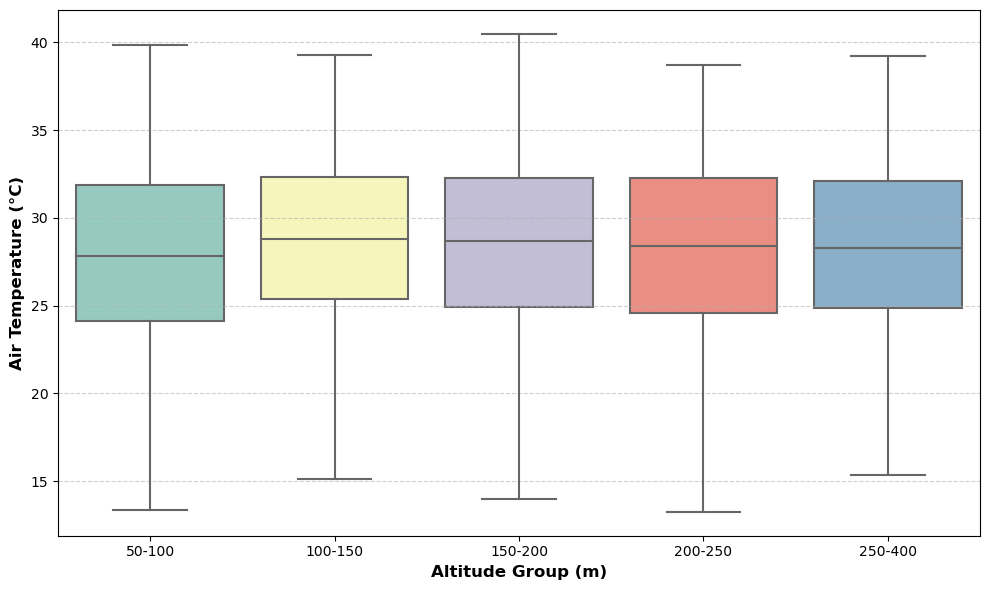

In [15]:
combined_df['Datetime'] = pd.to_datetime(combined_df['Datetime'])

# Correct 2022 periods
# periods = [
#     ('2022-02-19', '2022-02-23'),
#     ('2022-05-10', '2022-05-24'),
#     ('2022-06-11', '2022-06-21'),
#     ('2022-07-15', '2022-07-26'),
#     ('2022-10-24', '2022-10-31')
# ]

periods = [
     ('2022-06-11', '2022-06-21'),
     ('2022-07-15', '2022-07-26')
]

# Apply filter
mask = pd.Series(False, index=combined_df.index)
for start, end in periods:
    mask |= (combined_df['Datetime'] >= pd.to_datetime(start)) & (combined_df['Datetime'] <= pd.to_datetime(end))

df_filtered = combined_df[mask].copy()

# Ensure Altitude-group is treated as categorical with ordered levels
altitude_order = sorted(df_filtered['Altitude-group'].dropna().unique(), key=lambda x: int(x.split('-')[0]))
df_filtered['Altitude-group'] = pd.Categorical(df_filtered['Altitude-group'], categories=altitude_order, ordered=True)

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x='Altitude-group', y='Temp', palette='Set3', showfliers=False)

plt.xlabel("Altitude Group (m)", fontsize=12, weight='bold')
plt.ylabel("Air Temperature (°C)", fontsize=12, weight='bold')
#plt.title("Air Temperature by Altitude Group (Selected Periods)", fontsize=14, weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save or show
# plt.savefig("Tair_by_altitude_selected_periods.png", dpi=600)
plt.show()

In [16]:
# Compute basic statistics for each altitude group
stats_df = df_filtered.groupby('Altitude-group')['Temp'].agg(['min', 'max', 'mean', 'std'])

print(stats_df)

                  min    max       mean       std
Altitude-group                                   
50-100          13.37  39.85  27.929718  4.690816
100-150         12.53  39.30  28.693933  4.410270
150-200         13.20  40.48  28.415430  4.712047
200-250         13.25  38.70  28.219025  4.823495
250-400         15.37  39.23  28.382417  4.499943
